In [160]:
"""
Download the Bach chorales dataset and unzip it. 
!wget "https://homl.info/bach" -O bach.tgz
!tar -xvf "bach.tgz"

Train an RNN model that can predict the next time step (four notes), given a sequence of time steps from a chorale.  - 5 points

Then use this model to generate Bach-like music, one note at a time: 
you can do this by giving the model the start of a chorale and asking it to predict the next time step, - 3 points
then appending these time steps to the input sequence and asking the model for the next note, and so on.
"""

'\nDownload the Bach chorales dataset and unzip it. \n!wget "https://homl.info/bach" -O bach.tgz\n!tar -xvf "bach.tgz"\n\nTrain an RNN model that can predict the next time step (four notes), given a sequence of time steps from a chorale.  - 5 points\n\nThen use this model to generate Bach-like music, one note at a time: \nyou can do this by giving the model the start of a chorale and asking it to predict the next time step, - 3 points\nthen appending these time steps to the input sequence and asking the model for the next note, and so on.\n'

In [ ]:
#Download the Bach chorales dataset and unzip it. 
!wget "https://homl.info/bach" -O bach.tgz
!tar -xvf "bach.tgz"

In [153]:
import numpy as np
# After getting high loss, will try to standardize the data
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv("train/chorale_021.csv", index_col=None, header=0)
# Convert data to numpy array
data = df.to_numpy()
# Min-max scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataXScaler = scaler.fit_transform(data)

In [155]:
from keras.preprocessing.sequence import TimeseriesGenerator
# Using Keras TimeSeriesGenerator function to sequence the data with an X length of 3 and Y of 1. Data will be in sequential order
generator = TimeseriesGenerator(dataXScaler, dataXScaler, length=3, batch_size=32)

In [ ]:
from keras.layers import LSTM
from keras.layers import Dense, Dropout, BatchNormalization, TimeDistributed
from keras.models import Sequential
n_features = 4
# choose a number of time steps
n_steps = None

model = Sequential()
# Using TimeDistributed to apply Dense layer to every slice of input data
model.add(TimeDistributed(Dense(128), input_shape=(None, n_features)))
# LongTerm Short Memory layers as hidden layers - need return_sequences to be true so that next layer can handle input shape
model.add(LSTM(64, activation='relu', input_shape=(None, n_features), return_sequences=True))
# Batch normalization to keep dataset tight
model.add(BatchNormalization())

model.add(LSTM(32 , activation = 'relu'))
model.add(BatchNormalization())

model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

# fit model
model.fit_generator(generator, epochs=500)
# Credit to: http://kabhishek.me/blog/2020/04/05/lstm-bach-chorale

In [156]:
# Did separate training rounds with more datasets
model.fit_generator(generator, epochs=500)

Epoch 1/500
7/7 [==============================] - 0s 7ms/step - loss: 5.2497 - accuracy: 0.3348
Epoch 2/500
7/7 [==============================] - 0s 6ms/step - loss: 5.8423 - accuracy: 0.4208
Epoch 3/500
7/7 [==============================] - 0s 6ms/step - loss: 5.6411 - accuracy: 0.3258
Epoch 4/500
7/7 [==============================] - 0s 6ms/step - loss: 5.5247 - accuracy: 0.3620
Epoch 5/500
7/7 [==============================] - 0s 7ms/step - loss: 5.6265 - accuracy: 0.3710
Epoch 6/500
7/7 [==============================] - 0s 7ms/step - loss: 5.2976 - accuracy: 0.4208
Epoch 7/500
7/7 [==============================] - 0s 6ms/step - loss: 4.8170 - accuracy: 0.3846
Epoch 8/500
7/7 [==============================] - 0s 7ms/step - loss: 5.2210 - accuracy: 0.4796
Epoch 9/500
7/7 [==============================] - 0s 7ms/step - loss: 4.6456 - accuracy: 0.4253
Epoch 10/500
7/7 [==============================] - 0s 7ms/step - loss: 4.4160 - accuracy: 0.4118
Epoch 11/500
7/7 [===========

### Now try and predict the next timestep

In [157]:
# Using a validation dataset to test out timestep predictions
df = pd.read_csv("valid/chorale_231.csv", index_col=None, header=0)
data = df.to_numpy()
scaler = MinMaxScaler(feature_range=(0, 1))
dataXScalerValid = scaler.fit_transform(data)
# Getting subsample of the X data
x_input = dataXScalerValid[2:30]
# Reshape X data so that it can fit into model
x_input = x_input.reshape((1, len(x_input), 4))
# Getting predictions
yhat = model.predict(x_input, verbose=0)
# Reverse the scaler transformation on the data and print comparisions
print('actual ', scaler.inverse_transform(yhat))
print('expected: ', scaler.inverse_transform(dataXScalerValid)[30])

actual  [[69. 71. 55. 45.]]
expected:  [76. 68. 59. 52.]


### Generate Bach-like music, one note at a time

In [158]:
# Using a test dataset this time to generate the music
df = pd.read_csv("test/chorale_306.csv", index_col=None, header=0)
data = df.to_numpy()
scaler = MinMaxScaler(feature_range=(0, 1))
dataXScalerTest = scaler.fit_transform(data)
# Starting at the first note
start = np.array([dataXScalerTest[0]])
output = [scaler.inverse_transform(start)]
start = start.reshape((1, len(start), 4))

i = 1
while i < len(dataXScalerTest): # For the length of the test data
  # Run prediction
  yhat = model.predict(start, verbose=0)
  # Append the transformed prediction to a list for later analysis
  output.append(scaler.inverse_transform(yhat))
  # Reshape the predicted data so that it matches the format of input data
  yhat = yhat.reshape((1,len(yhat), 4))
  # Append predicted data to input data and repass it into predict function
  start = np.concatenate([start, yhat], axis=1)
  i += 1

In [159]:
output

[array([[69., 66., 61., 54.]]),
 array([[69., 61., 66., 45.]], dtype=float32),
 array([[69.015305, 61.      , 65.98129 , 45.      ]], dtype=float32),
 array([[69., 61., 55., 61.]], dtype=float32),
 array([[69., 61., 55., 61.]], dtype=float32),
 array([[69., 61., 55., 61.]], dtype=float32),
 array([[69., 61., 55., 61.]], dtype=float32),
 array([[78., 61., 55., 45.]], dtype=float32),
 array([[78., 61., 55., 45.]], dtype=float32),
 array([[69., 61., 66., 45.]], dtype=float32),
 array([[69., 61., 66., 45.]], dtype=float32),
 array([[69., 71., 55., 45.]], dtype=float32),
 array([[78., 61., 55., 45.]], dtype=float32),
 array([[69., 61., 55., 61.]], dtype=float32),
 array([[69., 71., 55., 45.]], dtype=float32),
 array([[78., 61., 55., 45.]], dtype=float32),
 array([[69., 71., 55., 45.]], dtype=float32),
 array([[69., 61., 66., 45.]], dtype=float32),
 array([[69., 61., 55., 61.]], dtype=float32),
 array([[78., 61., 55., 45.]], dtype=float32),
 array([[78., 61., 55., 45.]], dtype=float32),
 arr

1 point - CNN Game - `Add ScreenShot Image here.`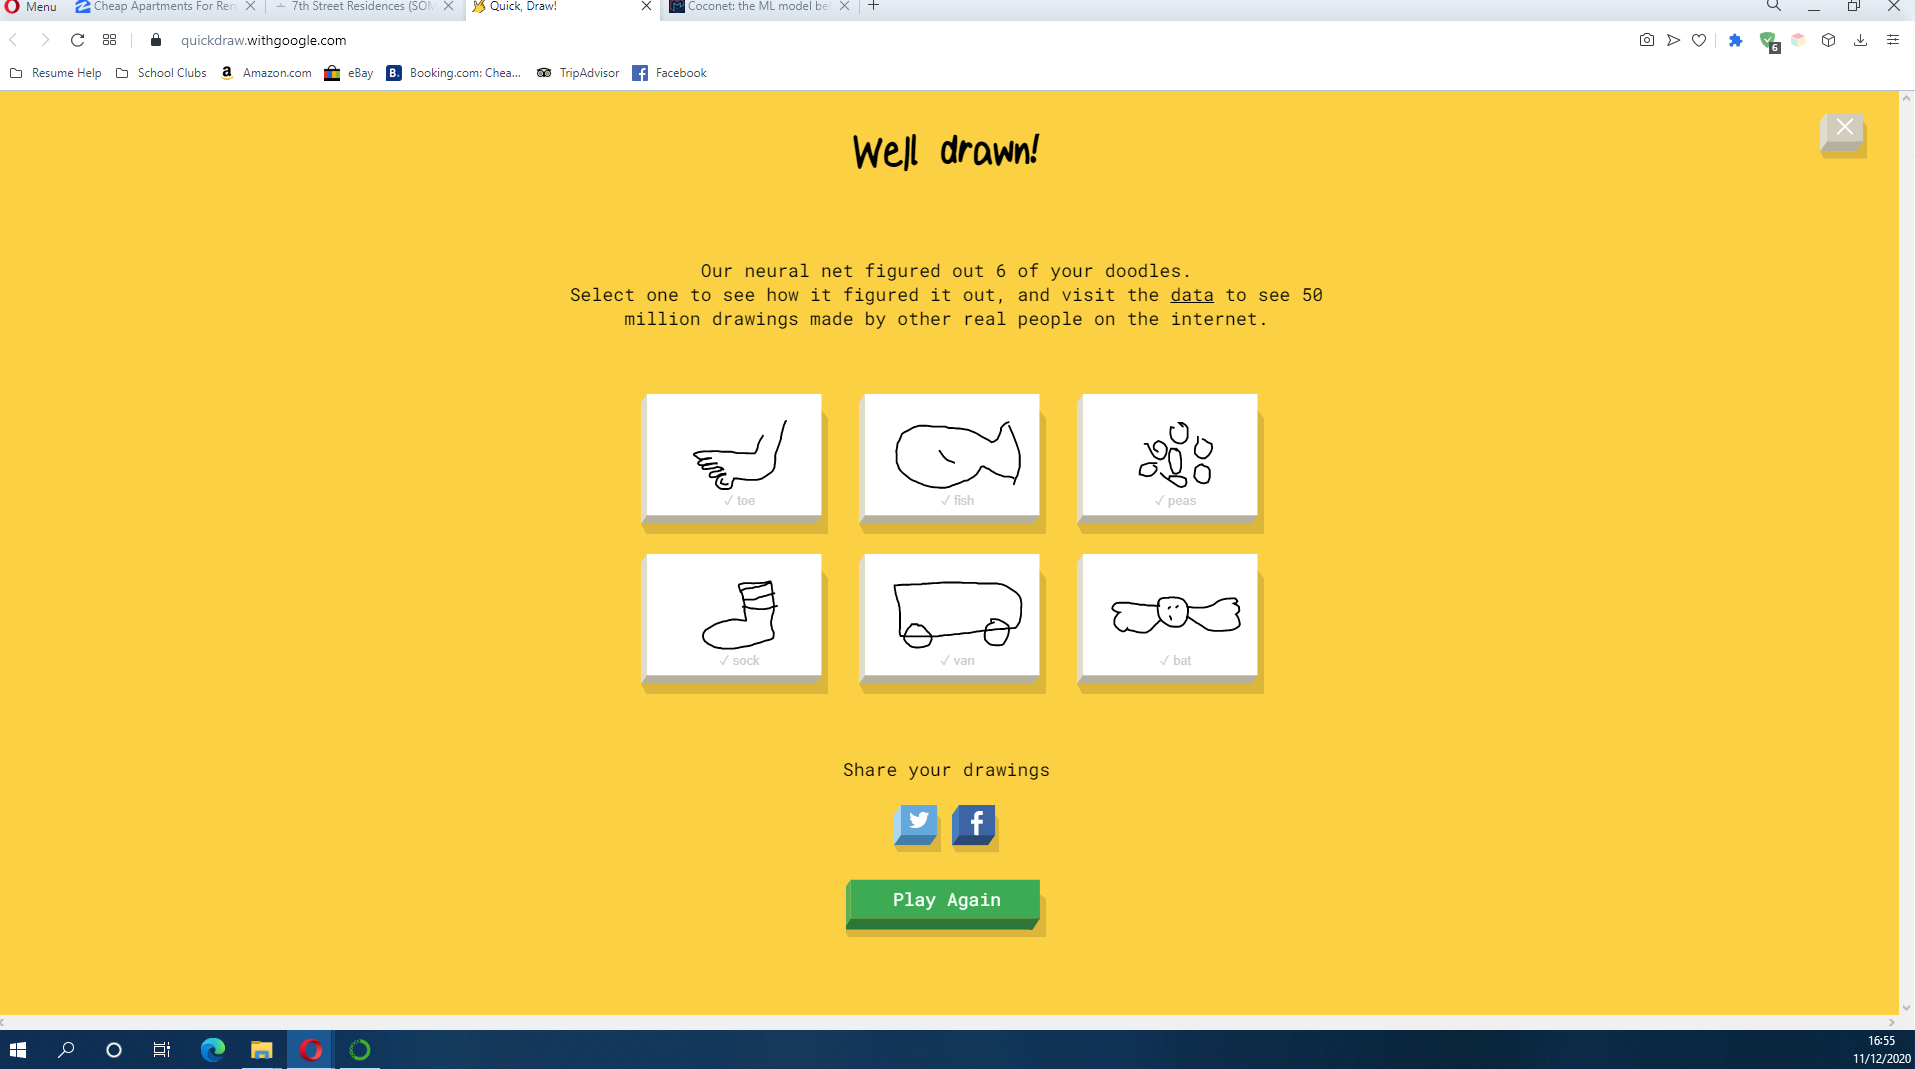

1 point - Peer Review - Add ScreenShot Image here.

**About dataset:**

Dataset: https://homl.info/bach
It is composed of 382 chorales composed by Johann Sebastian Bach. 
Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note’s index on a piano 
(except for the value 0, which means that no note is played). 

**Self-exercises:** - For your practice only. No grading on this part.

1. Can you think of a few applications for a sequence-to-sequence RNN? What about a sequence-to-vector RNN, and a vector-to-sequence RNN?

2. How many dimensions must the inputs of an RNN layer have? What does each dimension represent? What about its outputs?

3. If you want to build a deep sequence-to-sequence RNN, which RNN layers should have return_sequences=True? What about a sequence-to-vector RNN?

4. Suppose you have a daily univariate time series, and you want to forecast the next seven days. Which RNN architecture should you use?

5. What are the main difficulties when training RNNs? How can you handle them?

6. Can you sketch the LSTM cell’s architecture?

7. Why would you want to use 1D convolutional layers in an RNN?

8. Which neural network architecture could you use to classify videos?

Demo reference: https://www.datatechnotes.com/2018/12/rnn-example-with-keras-simplernn-in.html